# Overview of kernel


### Scope of kernel
1. Basic statistical distribution of data
2. Exploratory data-analysis
3. Data preperation
4. Build a baseline model
5. Dealing with class imbalances
    
    a. Oversampling (SMOTE)
    
    b. Varying the classes loss weight
    
    c. Reframe the problem as anomaly detection problem
    
    
6. Hyper-parameter tuning
7. Conclusion

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import matplotlib.gridspec as gridspec
import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report,recall_score, precision_score
from scipy.stats import kurtosis, skew
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE


import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")


rootDirectory = os.getcwd()
dataFile = os.path.join(rootDirectory,"data/creditcard-trainingsetv2.csv")
df = pd.read_csv(dataFile).dropna()
df = df.rename(columns = {"Seconds since reference time":"Seconds","Fraud? (1: Fraud, 0:  No Fraud)":"Fraud"})


# 1. Basic statistical description of data

In [2]:
df.shape

(227762, 32)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227762 entries, 0 to 227843
Data columns (total 32 columns):
Seconds       227762 non-null int64
Amount        227762 non-null float64
Fraud         227762 non-null int64
Feature 1     227762 non-null float64
Feature 2     227762 non-null float64
Feature 3     227762 non-null float64
Feature 4     227762 non-null float64
Feature 5     227762 non-null float64
Feature 6     227762 non-null float64
Feature 7     227762 non-null float64
Feature 8     227762 non-null float64
Feature 9     227762 non-null float64
Feature 10    227762 non-null float64
Feature 11    227762 non-null float64
Feature 12    227762 non-null float64
Feature 13    227762 non-null float64
Feature 14    227762 non-null float64
Feature 15    227762 non-null float64
Feature 16    227762 non-null float64
Feature 17    227762 non-null float64
Feature 18    227762 non-null float64
Feature 19    227762 non-null float64
Feature 20    227762 non-null float64
Feature 21    22776

In [4]:
df.describe()

,Seconds,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
count,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,...,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000,227762.000000
mean,79048.697979,90.839590,0.001805,0.049079,-0.005335,0.015329,-0.022775,-0.007300,0.009946,-0.005666,...,0.030630,-0.026713,0.003965,0.027317,0.033159,0.016709,-0.044825,0.076080,-0.001483,0.002429
std,39507.472207,250.542687,0.042441,0.933940,0.885131,0.872979,0.842622,0.819984,0.779157,0.761831,...,1.321453,1.228032,1.209617,8.652485,0.964472,1.019659,1.054534,1.032910,1.093376,1.123387
min,0.000000,0.000000,0.000000,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-28.009635,-34.830382,...,-26.160506,-43.557242,-73.216718,-14.999725,-19.214325,-5.791881,-18.683715,-4.797473,-24.588262,-13.434066
25%,47693.000000,6.000000,0.000000,-0.543241,-0.478569,-0.457522,-0.514805,-0.478224,-0.202770,-0.225624,...,-0.731680,-0.568990,-0.195185,-7.466647,-0.385973,-0.651170,-0.453309,-0.682565,-0.522648,-0.661881
50%,73252.500000,23.400000,0.000000,0.120822,0.060047,-0.045814,-0.025750,-0.006005,-0.051042,-0.034850,...,-0.237619,0.009823,0.033489,0.044075,0.067920,-0.001631,0.118488,0.030157,-0.093014,-0.067862
75%,120401.750000,79.990000,0.000000,0.724582,0.528894,0.410329,0.476367,0.468282,0.145100,0.168413,...,0.432489,0.532592,0.332262,7.521301,0.509103,0.686499,0.611636,0.835805,0.456928,0.613149
max,145245.000000,19656.530000,1.000000,5.825654,8.289890,9.253526,5.041069,5.591971,39.420904,27.202839,...,22.529298,36.877368,20.007208,14.999989,10.526766,4.569009,7.848392,12.018913,23.745136,15.594995


In [5]:
df['Fraud'].value_counts()

0    227351
1       411
Name: Fraud, dtype: int64

#### Key observations

1. The classes are not balanced with a ratio of 500:1 for no fraud to fraud
    
    a. Need to consider the recall of the model
    
    
2. The features are of different scale, for non-tree based models we need to scale the model to the same scale before inputting

    a. This is especially important for the amount 


# 2. Exploratory data analysis

Number of Negatives :  227351
Number of Positives :  411
Percentage of Fraud Positives: 0.18 %


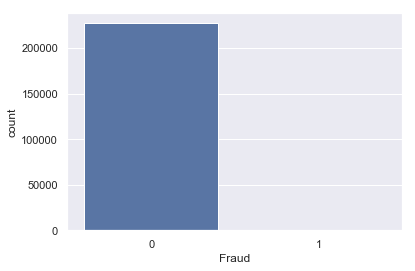

In [6]:
# Calculating percentage of Fraud Positives
ax = sns.countplot(df.Fraud,label="Count") 
A, B = df.Fraud.value_counts()
print('Number of Negatives : ', A)
print('Number of Positives : ', B)
print("Percentage of Fraud Positives: %.2f"%(df.Seconds[df["Fraud"]==1].count()/df.Seconds.count()*100),"%")

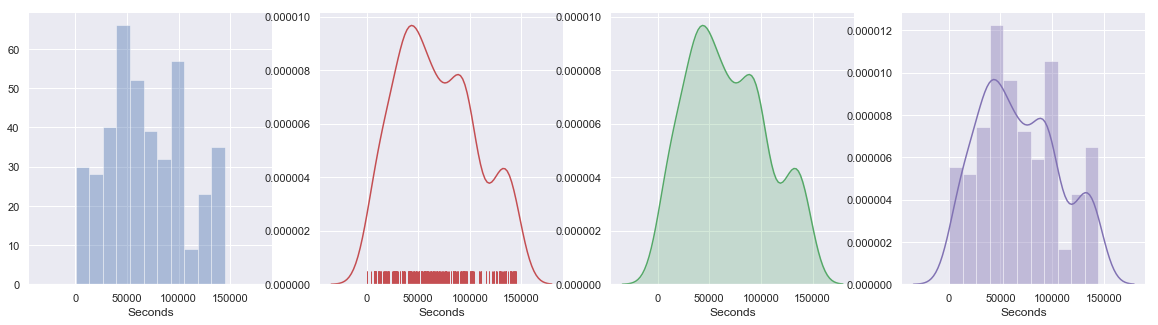

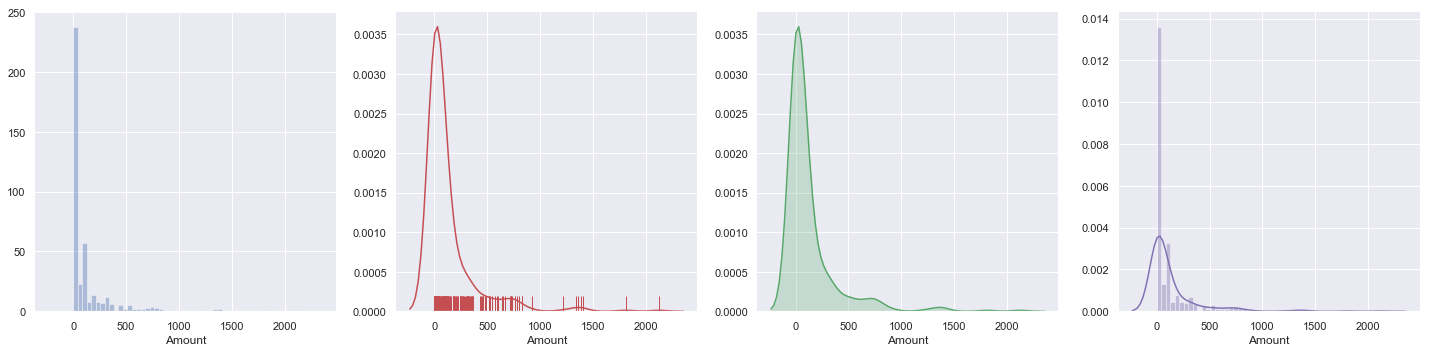

In [7]:
# Function for plotting continuous distributions

def dist_plot(d):
    f, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True)
    sns.despine(left=True)
    # Plot a simple histogram with binsize determined automatically
    sns.distplot(d, kde=False, color="b", ax=axes[0])

    # Plot a kernel density estimate and rug plot
    sns.distplot(d, hist=False, rug=True, color="r", ax=axes[1])

    # Plot a filled kernel density estimate
    sns.distplot(d, hist=False, color="g", kde_kws={"shade": True}, ax=axes[2])

    # Plot a histogram and kernel density estimate
    sns.distplot(d, color="m", ax=axes[3])

dist_plot(df[df["Fraud"]==1].Seconds)
dist_plot(df[df["Fraud"]==1].Amount)
plt.tight_layout()

#### Skewness and Kurtosis of the dataset

Skewness measures the asymmetry of a variable's probability distribution about its mean while kurtosis measures the "tailedness" of a variable's probability distribution (the sharpness of its peaks).

For Distribution of Transaction Amount, skewness and kurtosis can be observed to be extremely high. The distribution is heavily skewed towards zero and has extremely sharp peaks.

For Distribution of Transaction Time, there is much less skewness and kurtosis. The distribution has flatter peaks and is distributed more evenly than that of Transaction Amount. 

Excess Kurtosis of Normal Distribution of Amount: 514.37
Skewness of Normal Distribution of Amount: 14.07
Excess Kurtosis of Normal Distribution of Time: -1.11
Skewness of Normal Distribution of Time: 0.12


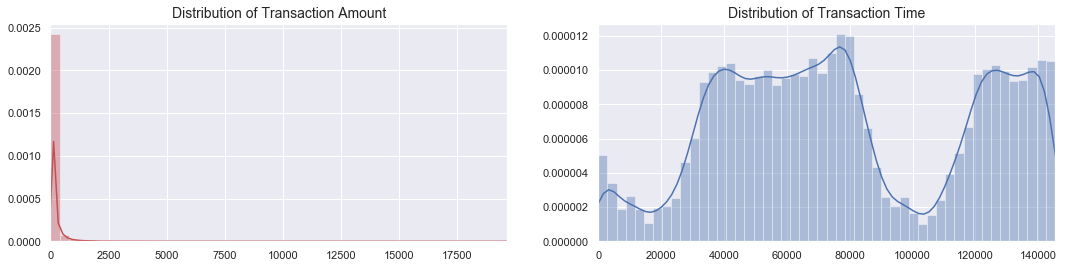

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Seconds'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

print("Excess Kurtosis of Normal Distribution of Amount: {0:.2f}".format(kurtosis(amount_val)))
print("Skewness of Normal Distribution of Amount: {0:.2f}".format(skew(amount_val)))
print("Excess Kurtosis of Normal Distribution of Time: {0:.2f}".format(kurtosis(time_val)))
print("Skewness of Normal Distribution of Time: {0:.2f}".format(skew(time_val)))

plt.show()

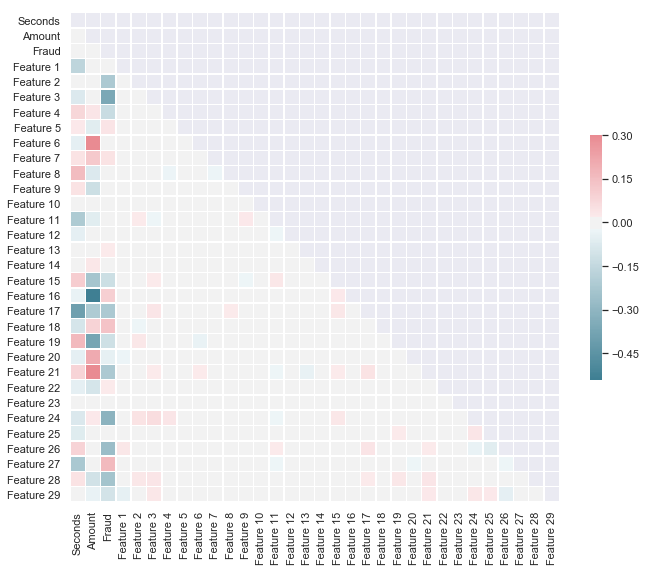

In [9]:
# plot correlation graphs
# visualise each features and look for outliers etc (histogram and scatter plots etc)
# possible for special 

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

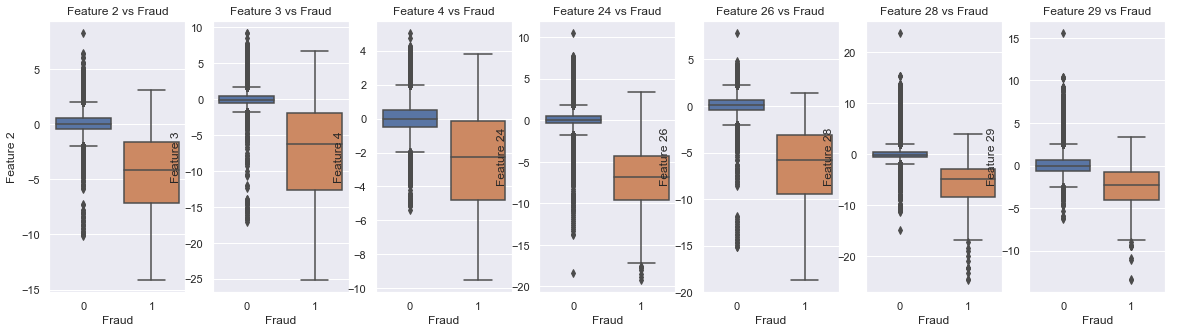

In [10]:
f, axes = plt.subplots(ncols=7, figsize=(20,5))

# Checking Correlations of variables with our Fraud
sns.boxplot(x="Fraud", y="Feature 2", data=df, ax=axes[0])
axes[0].set_title('Feature 2 vs Fraud')

sns.boxplot(x="Fraud", y="Feature 3", data=df, ax=axes[1])
axes[1].set_title('Feature 3 vs Fraud')

sns.boxplot(x="Fraud", y="Feature 4", data=df, ax=axes[2])
axes[2].set_title('Feature 4 vs Fraud')

sns.boxplot(x="Fraud", y="Feature 24", data=df, ax=axes[3])
axes[3].set_title('Feature 24 vs Fraud')

sns.boxplot(x="Fraud", y="Feature 26", data=df, ax=axes[4])
axes[4].set_title('Feature 26 vs Fraud')

sns.boxplot(x="Fraud", y="Feature 28", data=df, ax=axes[5])
axes[5].set_title('Feature 28 vs Fraud')

sns.boxplot(x="Fraud", y="Feature 29", data=df, ax=axes[6])
axes[6].set_title('Feature 29 vs Fraud')

plt.show()

# 3. Data preperation
#### Steps used in data preperation
1. Scaling of data
2. Feature engineering

    a. Utilizing t-sne to visualise before and after feature engineering

### 3.1 Scaling of data
Since most linear models (non-tree based) requires features to be roughly around the same scale to speed up the training process and provide better accuracy, it is vital to scale the models

In [11]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Seconds'].values.reshape(-1,1))
df.drop(['Seconds','Amount'], axis=1, inplace=True)

### 3.2 Feature engineering

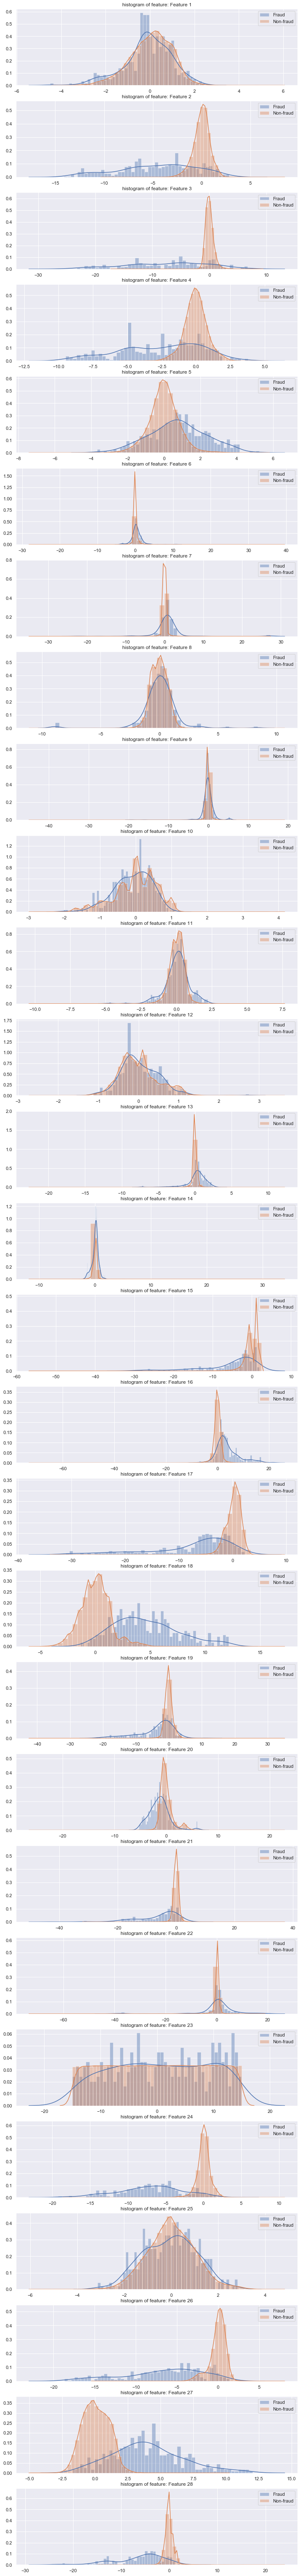

In [12]:
#Select only the anonymized features.
pca_features = df.ix[:,1:29].columns

plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[pca_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Fraud == 1], bins=50,label='Fraud')
    sns.distplot(df[cn][df.Fraud == 0], bins=50,label='Non-fraud')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
    ax.legend()
plt.show()

Feature 2,3,4,16,17,18,19,21,24,26,27,28 appear to have very different histogram distribution of Fraud and non-fraud. This might difference in distributions might be useful as indicators of fraud

In [13]:
df['Feature 2_'] = df['Feature 2'].map(lambda x: 1 if x < -4 else 0)
df['Feature 3_'] = df['Feature 3'].map(lambda x: 1 if x < -4 else 0)
df['Feature 4_'] = df['Feature 4'].map(lambda x: 1 if x < -3 else 0)
df['Feature 16_'] = df['Feature 16'].map(lambda x: 1 if x > 5 else 0)
df['Feature 17_'] = df['Feature 17'].map(lambda x: 1 if x < -5 else 0)
df['Feature 18_'] = df['Feature 18'].map(lambda x: 1 if x > 5 else 0)
df['Feature 19_'] = df['Feature 19'].map(lambda x: 1 if x < -5 else 0)
df['Feature 21_'] = df['Feature 21'].map(lambda x: 1 if x < -5 else 0)
df['Feature 24_'] = df['Feature 24'].map(lambda x: 1 if x < -5 else 0)
df['Feature 26_'] = df['Feature 26'].map(lambda x: 1 if x < -5 else 0)
df['Feature 27_'] = df['Feature 27'].map(lambda x: 1 if x > 4 else 0)
df['Feature 28_'] = df['Feature 28'].map(lambda x: 1 if x < -5 else 0)


#### 3.2.a Visualisation of training data before feature engineering

In [14]:
df_original = pd.read_csv(dataFile).dropna()
df_original = df_original.rename(columns = {"Seconds since reference time":"Seconds",
                                            "Fraud? (1: Fraud, 0:  No Fraud)":"Fraud"})


#Set df_original equal to all of the fraulent and 10,000 normal transactions.
df_orgFraud = df_original[df_original.Fraud == 1]
df_original = pd.concat([df_orgFraud, df_original[df_original.Fraud == 0].sample(n = 10000,random_state=42)], axis = 0)

#Scale features to improve the training ability of TSNE.
standard_scaler = StandardScaler()
df_original_std = standard_scaler.fit_transform(df_original)

#Set y equal to the target values.
y = df_original.Fraud.values
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df_original_std)
#Build the scatter plot with the two types of transactions.
color_map = {0:'red', 1:'blue'}
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

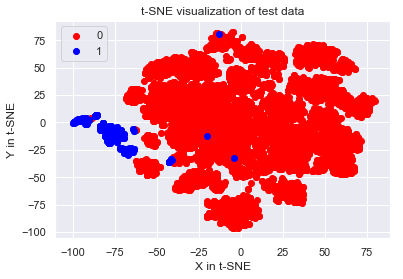

In [15]:
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()

##### 3.2.b Visualisation of the training data AFTER feature engineering

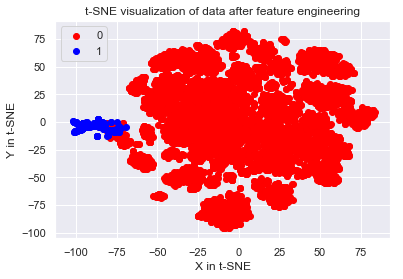

In [16]:
#Set df_used to the fraudulent transactions' dataset.
df_used = df[df.Fraud ==1]

#Add 10,000 normal transactions to df_used.
df_used = pd.concat([df_used, df[df.Fraud == 0].sample(n = 10000,random_state=42)], axis = 0)
#Scale features to improve the training ability of TSNE.
df_used_std = standard_scaler.fit_transform(df_used)

#Set y_used equal to the target values.
y_used = df_used.ix[:,-1].values
x_test_2d_used = tsne.fit_transform(df_used_std)
color_map = {0:'red', 1:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y_used)):
    plt.scatter(x=x_test_2d_used[y_used==cl,0], 
                y=x_test_2d_used[y_used==cl,1], 
                c=color_map[idx], 
                label=cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of data after feature engineering')
plt.show()

###### conclusion about feature engineering
As seen on the t-sne visualisation, after feature engineering the clusters of fraud are closer together and hence the linear classifier should be better able to seperate

# 4. Start with a baseline model

Comparing different classification models

In [17]:
X,Y = df.drop(['Fraud'],axis=1) , df.Fraud
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.25,
                                                    random_state=42)

In [18]:
# we will try out a dummy classifier to see
dummyClf = DummyClassifier(random_state=42, strategy="most_frequent")
dummyClf.fit(X_train,Y_train)
print(classification_report(Y_test,dummyClf.predict(X_test),target_names=['No Fraud',"Fraud"]))

#print accuracy score
dummyClf.fit(X_train,Y_train)
ypred = dummyClf.predict(X_test)
ytrue = Y_test
print("Dummy classifier obtained a baseline accuracy of {0:.3f}%".format(accuracy_score(ytrue,ypred)*100))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.00      0.00      0.00       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.50      0.50      0.50     56941
weighted avg       1.00      1.00      1.00     56941

Dummy classifier obtained a baseline accuracy of 99.819%


In [19]:
#we will next build a baseline with a logistic regression
logisticClf = LogisticRegression(random_state=42, solver='lbfgs',n_jobs = -1,max_iter=1000)
logisticClf.fit(X_train,Y_train)
print(classification_report(Y_test,logisticClf.predict(X_test),target_names=['No Fraud',"Fraud"]))


              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.88      0.69      0.77       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.94      0.84      0.89     56941
weighted avg       1.00      1.00      1.00     56941



In [20]:
#Utilizing Random Forest
rfClf = RandomForestClassifier(random_state=42,n_jobs=-1)
rfClf.fit(X_train,Y_train)
print(classification_report(Y_test,rfClf.predict(X_test),target_names=['No Fraud',"Fraud"]))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.99      0.77      0.86       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.99      0.88      0.93     56941
weighted avg       1.00      1.00      1.00     56941



In [21]:
#utilzing xgboost
xgClf = XGBClassifier(n_jobs = -1,random_state=42)
xgClf.fit(X_train,Y_train)
print(classification_report(Y_test,xgClf.predict(X_test),target_names=['No Fraud',"Fraud"]))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.93      0.79      0.85       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.97      0.89      0.93     56941
weighted avg       1.00      1.00      1.00     56941



#### Conclusion after preliminary baselines
After no hyperparamter tuning and no experimentation with the different cost and sampling methods, it seems that the random forest algorithm produces the best baseline F1-score of 0.86 on the test set.

##### Choice of metric
For such a skewed dataset like credit card fraud, it is important to note that accuracy should neve be used as a metric as an naive implmentation of a dummy classifier (predicting all non-fraud) is able to achieve an accuracy of 
99.8 percent. 

The F1 score achieves a nice balance of precision(when we predict a fraud case, how often are we right) and recall(out of all the fraud cases,how many of them did we actually predict) and hence is ideal for our particular problem set

When comparing performance of different algorithms we will now consider the F1-score instead of accuracy

# 5. Dealing with class imbalances
#### Note the classes are extremely inbalanced hence to solve this problem we will employ the following techniques 
 a. Sampling
 
 b. Cost sensitive learning for the other classes
 
 c. Reframe as an anomaly detection problem


### 5.a Oversampling using SMOTE

To illustrate the effects of SMOTE we will compare the F1-score of models train on non-smote dataset and smote dataset. 

In [22]:
Y_train.value_counts()
smt = SMOTE(ratio=1/50)
X_train_smote, Y_train_smote = smt.fit_sample(X_train, Y_train)
print(np.bincount(Y_train_smote))

[170513   3410]


In [23]:
logisticClf = LogisticRegression(random_state=42, solver='lbfgs',n_jobs = -1,max_iter=1000)
logisticClf.fit(X_train,Y_train)
print('Non- Smote dataset for logistic regression')
print(classification_report(Y_test,logisticClf.predict(X_test),target_names=['No Fraud',"Fraud"]))

Non- Smote dataset for logistic regression
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.88      0.69      0.77       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.94      0.84      0.89     56941
weighted avg       1.00      1.00      1.00     56941



In [24]:
#Retrain on smote dataset
logisticClf.fit(X_train_smote,Y_train_smote)
print('Smote dataset for logistic regression')
print(classification_report(Y_test,logisticClf.predict(X_test),target_names=['No Fraud',"Fraud"]))

Smote dataset for logistic regression
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.81      0.83      0.82       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.91      0.92      0.91     56941
weighted avg       1.00      1.00      1.00     56941



In [25]:
print('Non-smote dataset for random forest')
print(classification_report(Y_test,rfClf.predict(X_test),target_names=['No Fraud',"Fraud"]))

Non-smote dataset for random forest
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.99      0.77      0.86       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.99      0.88      0.93     56941
weighted avg       1.00      1.00      1.00     56941



In [26]:
print('Smote dataset for random forest')
rfClf.fit(X_train_smote,Y_train_smote)
print(classification_report(Y_test,rfClf.predict(X_test),target_names=['No Fraud',"Fraud"]))

Smote dataset for random forest
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.96      0.83      0.89       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.98      0.91      0.94     56941
weighted avg       1.00      1.00      1.00     56941



In [27]:
xgClf = XGBClassifier(n_jobs = -1,random_state=42)
xgClf.fit(X_train,Y_train)
print('Non-smote dataset for xgboost')
print(classification_report(Y_test,xgClf.predict(X_test),target_names=['No Fraud',"Fraud"]))

Non-smote dataset for xgboost
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.93      0.79      0.85       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.97      0.89      0.93     56941
weighted avg       1.00      1.00      1.00     56941



In [28]:
xgClf.fit(X_train_smote,Y_train_smote)
print('Smote dataset for xgboost')
print(classification_report(Y_test,xgClf.predict(X_test.as_matrix()),target_names=['No Fraud',"Fraud"]))

Smote dataset for xgboost
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.84      0.85      0.85       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.92      0.93      0.92     56941
weighted avg       1.00      1.00      1.00     56941



After utilizing SMOTE, it seems that the F1-score of the logistic regression has improved from 0.77 to 0.82. In addition, the F1-score of random forest has improved from 0.86 to 0.88 

### 5.b Effects of changing classes weights on precision & recall

Now we will experiment with assigning different cost weightage to the differenct classes, and visualise its effects on precision and recall. For the sake of simplicity, we will only be analyzing the effects on logistic regression problem

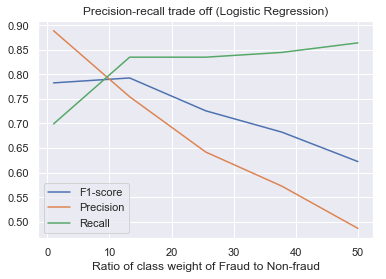

In [29]:
yAxisLog = []
xAxisLog = []
yAxisRec = []
yAxisPrec = []
for i in np.linspace(1,50,5):
    logClf = LogisticRegression(random_state=42,n_jobs = -1,class_weight={1:i})
    logClf.fit(X_train,Y_train)
    yAxisLog.append(f1_score(Y_test,logClf.predict(X_test)))
    yAxisPrec.append(precision_score(Y_test,logClf.predict(X_test)))
    yAxisRec.append(recall_score(Y_test,logClf.predict(X_test)))
    xAxisLog.append(i)

plt.plot(xAxisLog,yAxisLog,label="F1-score")
plt.plot(xAxisLog,yAxisPrec,label="Precision")
plt.plot(xAxisLog,yAxisRec,label="Recall")
plt.legend()
plt.title("Precision-recall trade off (Logistic Regression)")
plt.xlabel('Ratio of class weight of Fraud to Non-fraud')
plt.show()

Key findings

This graph illustrates the precision-recall trade off. By increasing the weight on the fraud detection the corresponding preciison will fall and the recall will increase. As seen there is a precision-recall trade off and we should instead try to optimise the f1-score which best balances both competing objective. 

As such we will treat the cost weightage as a hyper-parameter tuning parameter to tune it.

### 5.c Utilizing an anomaly detection model



We will consider two of the most popular anomaly detection model namely: 

1. Isolation Forest Algorithm  
2. Local Outlier Factor (LOF) ALgorithm


In [30]:
outlier_fraction = 411.0/227762 #there are 411 frauds with 227 762 entries
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=42, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction)}

In [31]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_test)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_test)
    else:    
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y_test).sum()
    
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y_test,y_pred))
    print("Classification Report :")
    print(classification_report(Y_test,y_pred))

Isolation Forest: 76
Accuracy Score :
0.9986652851196853
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56838
           1       0.65      0.57      0.61       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.82      0.79      0.80     56941
weighted avg       1.00      1.00      1.00     56941

Local Outlier Factor: 162
Accuracy Score :
0.9971549498603818
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56838
           1       0.21      0.21      0.21       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.61      0.61      0.61     56941
weighted avg       1.00      1.00      1.00     56941



Key findings

Based on the evidence, our classification models actually perform better than the anomaly detection models.This could have been possibly due to the fact that the classification models employed are models with high capacity to learn the numerous factors

# 6. Hyperparameter tuning

We will now focus our efforts of tuning the classification models

In [32]:
# specify parameters and distributions to sample from
param_dist = {"n_estimators" :sp_randint(50,200),
              "max_depth": sp_randint(3, 50),
              "max_features": sp_randint(1, 30),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             }


rfClf = RandomForestClassifier()


# run randomized search
n_iter_search = 5
random_search_rf = RandomizedSearchCV(rfClf, param_distributions=param_dist,scoring='f1',
                                   n_iter=n_iter_search, cv=3,n_jobs = -1)

start = time.time()
random_search_rf.fit(X_train_smote, Y_train_smote)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
# print(random_search_rf.cv_results_,random_search_rf.best_params_)


#Fit the model with the best parameters and evaluate the outcome
rfClf = RandomForestClassifier(**random_search_rf.best_params_)
rfClf.fit(X_train_smote,Y_train_smote)
print(classification_report(Y_test,rfClf.predict(X_test),target_names=['No Fraud',"Fraud"]))

RandomizedSearchCV took 1446.41 seconds for 5 candidates parameter settings.
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56838
       Fraud       0.97      0.83      0.90       103

   micro avg       1.00      1.00      1.00     56941
   macro avg       0.98      0.92      0.95     56941
weighted avg       1.00      1.00      1.00     56941



In [33]:
xgClf = XGBClassifier(n_jobs = -1,random_state=42)
param_dist = {"max_depth": sp_randint(3, 50),
              "n_estimators": [50,200],
              "booster": ['gbtree','gblinear','dart']
             }

random_search_xg = RandomizedSearchCV(xgClf, param_distributions=param_dist,scoring='f1',
                                   n_iter=n_iter_search, cv=3)

start = time.time()
random_search_xg.fit(X_train_smote, Y_train_smote)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
print(random_search_xg.cv_results_,random_search_xg.best_params_)

#Fit the model with the best parameters and evaluate the outcome
xgClf = XGBClassifier(**random_search_xg.best_params_)
xgClf.fit(X_train_smote,Y_train_smote)
print(classification_report(Y_test,xgClf.predict(X_test.as_matrix()),target_names=['No Fraud',"Fraud"]))

RandomizedSearchCV took 172.22 seconds for 5 candidates parameter settings.
{'mean_fit_time': array([30.39102991,  1.76095732,  5.36864058,  0.55385288,  1.75962822]), 'std_fit_time': array([1.13288469e+00, 5.54309418e-03, 1.62662039e-02, 4.69797880e-04,
       1.02463856e-02]), 'mean_score_time': array([0.10006515, 0.03856285, 0.05352338, 0.03889473, 0.03756499]), 'std_score_time': array([4.48480475e-03, 4.70246438e-04, 3.08276370e-03, 1.07214749e-06,
       4.70527427e-04]), 'param_booster': masked_array(data=['dart', 'gblinear', 'dart', 'gblinear', 'gblinear'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[41, 40, 8, 41, 31],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[200, 200, 50, 50, 200],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=

# 7. Conclusion

Based on the results above, we can see that through the efforts of utilization of feature engineering and SMOTE coupled with hyperparamter tuning, we are able to raise the f1-score of Random forest to 0.91 from 0.86.